In [1]:
import pandas as pd
import numpy as np
import pickle
from gensim.models import KeyedVectors
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import pearsonr
from wordcloud import WordCloud
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
domains = ['brand', 'good', 'trait', 'food', 'occupation', 'risk', 'people']
dims = [('sincere','exciting'),
        ('hedonic','utilitarian'),
        ('masculine','feminine'),
        ('tasty','nutritious'),
        ('significance','autonomy'),
        ('dread-inducing','unknowable'),
        ('warm', 'competent')]

In [3]:
with open("data/dict_of_Xs.pickle", "rb") as handle:
    dict_of_Xs = pickle.load(handle)
    
with open("data/dict_of_ys.pickle", "rb") as handle:
    dict_of_ys = pickle.load(handle)

In [4]:
common_words = pd.read_csv('ratings_wordfreq.csv', usecols=[0]).iloc[:,0].values
common_words[:5]

array(['a', 'abandon', 'ability', 'able', 'abortion'], dtype=object)

In [5]:
wv_from_bin = KeyedVectors.load_word2vec_format(fname="GoogleNews-vectors-negative300.bin", binary=True)  # C binary format

In [6]:
common_word_vectors = []
words_for_index = []

for word in common_words:
    try:
        vec = wv_from_bin[word]
    except KeyError:
        continue
    common_word_vectors.append(vec)
    words_for_index.append(word)

common_word_vectors_df = pd.DataFrame(common_word_vectors, index=words_for_index)
common_word_vectors_df.head()

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
abandon,0.007660,0.078613,0.109375,0.339844,-0.208984,0.044678,-0.036621,-0.041992,0.192383,0.139648,...,-0.033203,0.355469,-0.205078,0.080566,-0.137695,-0.089355,0.199219,0.141602,0.107910,0.259766
ability,0.238281,0.125000,-0.056641,0.050049,-0.056885,-0.025146,0.091797,-0.032959,0.092773,-0.010010,...,-0.144531,0.173828,-0.172852,-0.251953,-0.136719,0.242188,0.160156,0.063965,-0.279297,0.026855
able,0.187500,0.068359,-0.011230,0.178711,-0.207031,-0.106445,0.195312,0.032227,0.193359,-0.125977,...,-0.116211,0.102051,-0.088867,-0.117188,-0.111816,0.117676,0.101562,0.005524,-0.021851,-0.179688
abortion,0.031738,0.097168,0.273438,0.363281,-0.306641,-0.202148,0.127930,0.123047,0.106934,-0.145508,...,0.386719,-0.464844,0.014160,0.030029,-0.035645,0.457031,0.531250,0.154297,0.065430,0.199219
about,0.202148,-0.081055,0.183594,-0.136719,-0.048584,0.105957,0.063477,-0.109863,0.146484,0.211914,...,-0.156250,0.115234,-0.126953,0.059814,-0.106934,-0.083008,-0.035156,0.066406,0.053711,-0.171875


In [7]:
common_word_vectors_df.to_csv('data/frequent_coca_word_vectors.csv')

brand
	 sincere


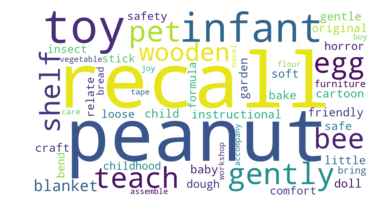

	 exciting


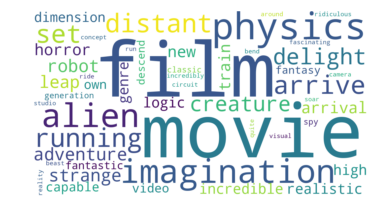

good
	 hedonic


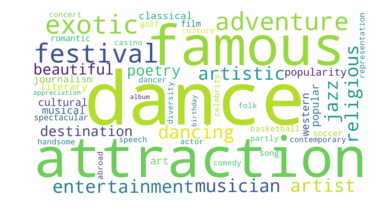

	 utilitarian


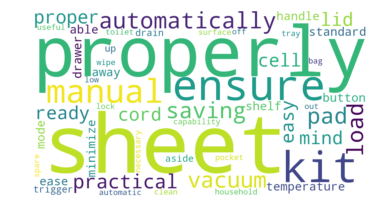

trait
	 masculine


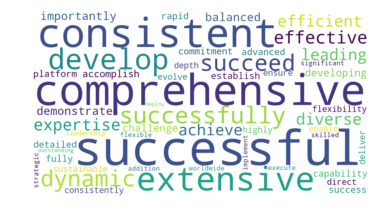

	 feminine


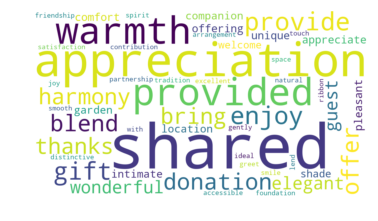

food
	 tasty


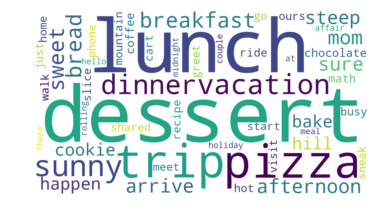

	 nutritious


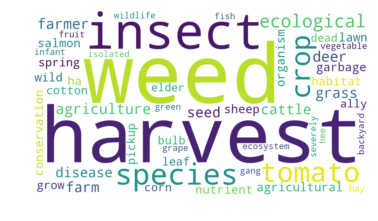

occupation
	 significance


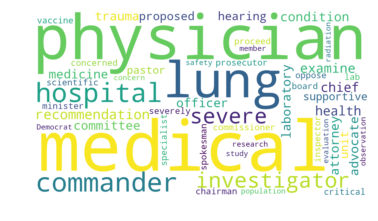

	 autonomy


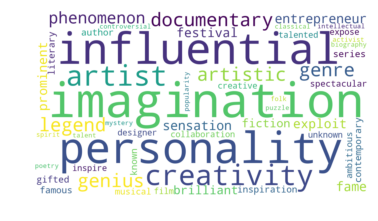

risk
	 dread-inducing


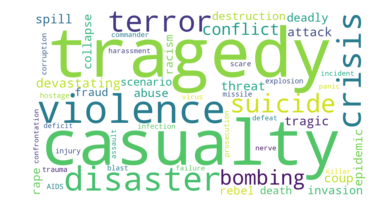

	 unknowable


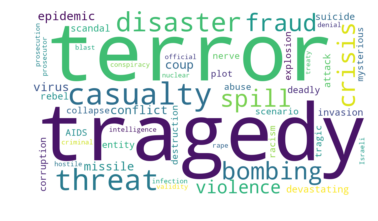

people
	 warm


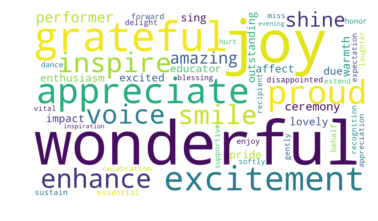

	 competent


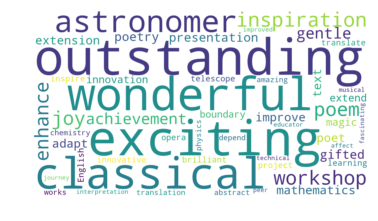

In [8]:
for domain, dim_pair in zip(domains, dims):
    print(domain)
    for dim in dim_pair:
        print('\t', dim)
        judgment_target_vectors = dict_of_Xs[domain]
        judgment_target_words = judgment_target_vectors.index
        judgments = dict_of_ys[dim]
        similarities = cosine_similarity(X=judgment_target_vectors, Y=common_word_vectors_df.values)
        associations = np.apply_along_axis(func1d=lambda x: pearsonr(x, judgments.values)[0], axis=0, arr=similarities)
        associations_ser = pd.Series(associations, index=words_for_index)
        masking_array = ~associations_ser.index.isin(judgment_target_words) # to remove COCA words that are also judgment words
        associations_ser = associations_ser[masking_array]
        associations_ser.to_csv(f'results/judgment_associations/{dim}.csv')
        
        associations_dict = associations_ser.to_dict()
        wordcloud = WordCloud(width=1350, height=750, max_words=50, background_color='white', 
                              relative_scaling=1, normalize_plurals=False).generate_from_frequencies(associations_dict)

        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis("off")
        plt.savefig(fname=f'figures/association_wordclouds/{dim}.png')
        plt.show()